# Data Wrangling

Let us import all of our packages and load in the data (2013-2023)

In [2]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [3]:
pbp = nfl.import_pbp_data(range(2014,2024))

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [26]:
print(pbp.shape)

(202927, 397)


# Section 1 - General
Goals:

- Filter pbp dataset to only include pass attempts
- Group by players and summarize the average epa (expected points added) and total attempts
- Visualize our results

In [4]:
pbp = pbp[pbp["pass_attempt"] == 1]

In [5]:
pbp_grouped = pbp.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa=('epa', 'mean'), sum_att=('pass_attempt', 'sum'))
pbp_filtered = pbp_grouped[pbp_grouped["sum_att"] > 500]
pd.set_option('display.max_rows', None)
pbp_filtered = pbp_filtered.sort_values(by="mean_epa", ascending=False)

In [6]:
pbp_filtered.head(20)

,team,mean_epa,sum_att
passer_player_name,,,
B.Purdy,SF,0.260180,833.0
P.Mahomes,KC,0.222529,4455.0
T.Romo,DAL,0.184863,655.0
T.Brady,TB,0.156850,6715.0
D.Brees,NO,0.155805,4176.0
A.Rodgers,NYJ,0.137633,5241.0
J.Garoppolo,LV,0.135447,2180.0
J.Love,GB,0.132817,754.0
P.Rivers,IND,0.126503,4393.0


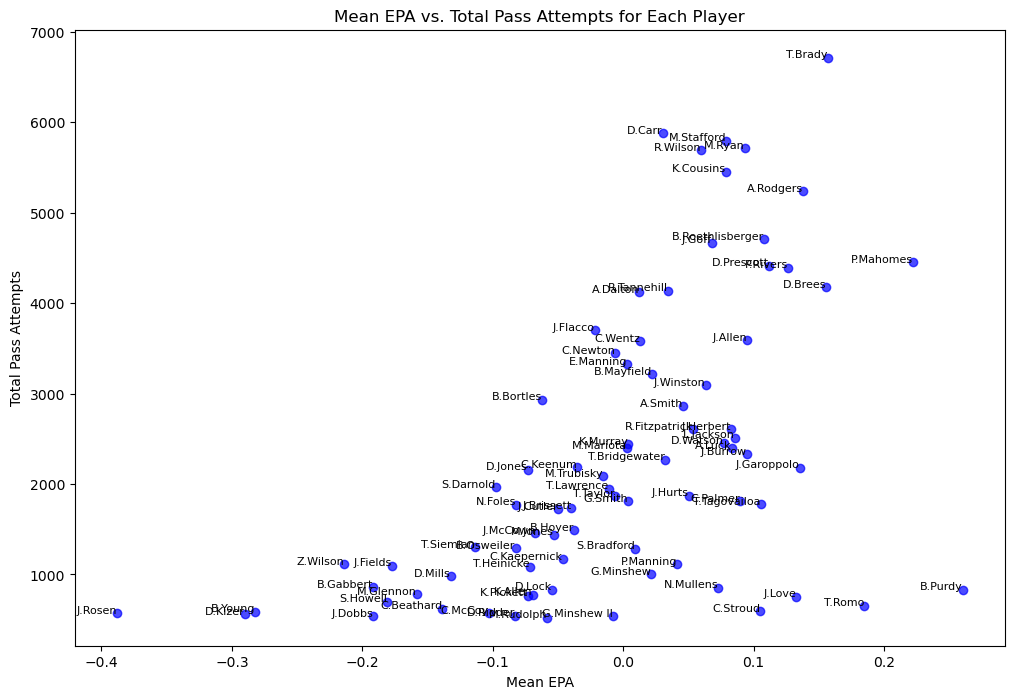

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(pbp_filtered['mean_epa'], pbp_filtered['sum_att'], color='blue', alpha=0.7)

plt.xlabel('Mean EPA')
plt.ylabel('Total Pass Attempts')
plt.title('Mean EPA vs. Total Pass Attempts for Each Player')

for player, row in pbp_filtered.iterrows():
    plt.annotate(player, (row['mean_epa'], row['sum_att']), fontsize=8, ha='right')

plt.show()


# Section 2 - Getting the weather columns

There is a weather column in our dataset. Now what does that look like? Let's see.

In [9]:
pbp["weather"].head()

4     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
7     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
8     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
9     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
12    Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
Name: weather, dtype: object

As we can see, it is a string of a lot of information, like temperature, humidity, and wind speed. Our goal will be to extract each of these pieces of information.

## Extracting the weather

Based on our initial analysis, it seems like the first word tells us what the weather is. What does this look like?

In [12]:
pbp['first_word_weather'] = pbp['weather'].str.split().str[0]
pbp["first_word_weather"].value_counts()

/var/folders/6q/jmrgx0xj5t7b7l152lzdznmr0000gn/T/ipykernel_64647/4258186487.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp['first_word_weather'] = pbp['weather'].str.split().str[0]


first_word_weather
Cloudy           47717
Sunny            41210
Partly           22712
Temp:            20938
Clear            16710
Mostly           14828
Rain              6961
Controlled        6077
N/A               6070
Fair              2601
Indoors           2226
Overcast          1555
Cloudy,           1430
Light             1395
Snow               852
Sunny,             737
Indoor             651
Hazy               436
Clear,             400
cloudy             305
Rainy              292
No                 250
clear              223
T:                 223
Cold               222
sunny              199
Scattered          196
Foggy              170
0%                 160
n/a                159
Party              147
SUNNY              145
partly             138
Showers            130
Thunderstorms       99
Mosly               92
Mid                 91
Outdoor             89
Dry                 87
Steady              84
Climate             83
Zero                79
sUNNY          

As we can see, a lot of synonyms. We could use AI to group them but I will just do it manually. We can also see that many entries do not have proper weather entries. We are going to organize these terms into three categories: cloudy, sunny, and rainy (percpitiation). The rest of the terms do not matter.

In [13]:
pbp['is_sunny'] = np.where(pbp['weather'].str.contains('sunny|clear', case=False, na=False), 1, 0)
pbp['is_cloudy'] = np.where(pbp['weather'].str.contains('Cloudy | Cloudly', case=False, na=False), 1, 0)
pbp['is_percipitation'] = np.where(pbp['weather'].str.contains('Rain | Raining, | scattered | Raining | Thunderstorms | Showers | Scattered | Snow | Flurries | Scattered', case=False, na=False), 1, 0)

print(pbp[["is_sunny", "is_cloudy", "is_percipitation"]].mean())

/var/folders/6q/jmrgx0xj5t7b7l152lzdznmr0000gn/T/ipykernel_64647/1513259754.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp['is_sunny'] = np.where(pbp['weather'].str.contains('sunny|clear', case=False, na=False), 1, 0)
/var/folders/6q/jmrgx0xj5t7b7l152lzdznmr0000gn/T/ipykernel_64647/1513259754.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp['is_cloudy'] = np.where(pbp['weather'].str.contains('Cloudy | Cloudly', case=False, na=False), 1, 0)


is_sunny            0.336594
is_cloudy           0.379742
is_percipitation    0.052960
dtype: float64


/var/folders/6q/jmrgx0xj5t7b7l152lzdznmr0000gn/T/ipykernel_64647/1513259754.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp['is_percipitation'] = np.where(pbp['weather'].str.contains('Rain | Raining, | scattered | Raining | Thunderstorms | Showers | Scattered | Snow | Flurries | Scattered', case=False, na=False), 1, 0)


Now what does the average EPA look like in each of these weather conditions?

In [14]:
mean_epa_sunny = pbp.loc[pbp["is_sunny"] == 1, "epa"].mean()
mean_epa_cloudy = pbp.loc[pbp["is_cloudy"] == 1, "epa"].mean()
mean_epa_rainy = pbp.loc[pbp["is_percipitation"] == 1, "epa"].mean()
print(mean_epa_sunny, mean_epa_cloudy, mean_epa_rainy)

0.030000351 0.022475053 -0.043500226


We do not have many entries, but we can clearly see the **epa goes down significantly when it is rainy.** 

## Temperature

Temperature is a **continuous** variable which means we need to treat it slightly different. First, let us extract it from the weather column.

In [19]:
pbp['temperature'] = pbp['weather'].str.extract(r'([-+]?\d+)(?=°)', expand=False)
pbp['temperature'] = pd.to_numeric(pbp['temperature'], errors='coerce')
print(pbp["temperature"].head(10))

4     74.0
7     74.0
8     74.0
9     74.0
12    74.0
15    74.0
18    74.0
23    74.0
25    74.0
26    74.0
Name: temperature, dtype: float64


And now let us look at how players perform in below freezing weather. This won't be a factor in our model, but it will be cool to see.

In [21]:
pbp["is_cold"] = np.where(pbp["temperature"] <= 32, 1, 0)
print(pbp["is_cold"].mean())
pbp_cold = pbp[pbp["is_cold"] == 1]
mean_epa_cold = pbp.loc[pbp["is_cold"] == 1, "epa"].mean()
print(f"EPA in cold weather: {mean_epa_cold}")

0.04917039132298807
EPA in cold weather: -0.016088498756289482


It is cold in around 5 percent of games and QB performance decreases significantly.

## Wind

Next, we will do wind which is very similar to temperature. Let's extract it from the weather column once again.

In [29]:
pbp['wind_speed'] = pbp['weather'].str.extract(r'(\d+)\s*mph')[0].astype(float)
pbp["wind_speed"] = pd.to_numeric(pbp['wind_speed'], errors='coerce')
pbp["wind_speed"].head(10)

4     3.0
7     3.0
8     3.0
9     3.0
12    3.0
15    3.0
18    3.0
23    3.0
25    3.0
26    3.0
Name: wind_speed, dtype: float64

According to the internet(?) windy games are games with speeds greater than or equal to 15 mph because this can really effect the ball. How to QBs perform in this scenario?

In [30]:
pbp["is_windy"] = np.where(pbp["wind_speed"] >= 15, 1, 0)
print(pbp["is_windy"].mean())
pbp_windy = pbp[pbp["is_windy"] == 1]
mean_epa_windy = pbp.loc[pbp["is_windy"] == 1, "epa"].mean()
print(f"EPA in windy weather: {mean_epa_windy}")

0.08998802525045953
EPA in windy weather: -0.018401216715574265


This situation occurs in roughly 9 percent of instances and as expected, QB performance goes down.

## Preparing data for models

Lastly, we are going to group by games to get EPA per game and prepare our model for the OLS regression and XGBoost. Additionally exporting as csv.

In [32]:
pbp_games = pbp.groupby(["game_id", "passer_player_name"]).agg(sum_epa=("epa", "sum"), att = ("pass_attempt", "sum"), yards = ("passing_yards", "sum"), mean_temp=("temperature", "mean"), is_sunny=("is_sunny","max"), is_cloudy=("is_cloudy","max"), is_rainy = ("is_percipitation", "max"), mean_wind = ("wind_speed", "mean"), is_cold = ("is_cold", "max"), is_windy = ("is_windy", "max")).reset_index()
pbp_games.to_csv('for_model.csv', index=False)